# Predicting Star Ratings of Edinburgh Airbnbs through Review Texts Analysis

# Notebook 4: Modelling_Review_Uncollapsed

# Introduction

In this notebook, we will further process and analyse our Airbnb reviews using natural language processing (NLP) and machine learning techniques. We will first define a customized tokenizer to remove any irrelevant contents from the text and separate the review texts into individual words. Next, we will set up for modelling stage including define the Baseline Score for future model evaluation.  After that, we will utilize different machine learning models and attempt to find the best-performing models by tuning hyperparameters using GridSearch. Finally, we will use evaluation metrics to assess our results.

**Note**: The review data used in this notebook is the cleaned and processed review dataset with listing information aggregated to each review. The reviews are **not collapsed** to each Airbnb Listing. This means that multiple datapoints with different reviews will share same listing information and pre-defined overall rating sentiment score.

### Brief summary

- First, define a customized tokenizer to further process our review texts.
- Second, set up our modeling stage by checking if our target variable is balanced, and define several helper functions for future use.
- Third, define a baseline model to compare our future model accuracy.
- Finally, use several gridsearches to find the best model with best model performance and model interpretability.

***

# Table of Contents

1. [**Import Libraries**](#a1)<br>

2. [**Customized Tokenizer**](#a2)<br>
    
3. [**Modelling Set Up**](#a3)<br>
    3.1.[Split Variables](#a3.1)<br>
    3.2.[Target Varaible Distribution](#a3.2)<br>
    3.3.[Train Test Split](#a3.3)<br>
    3.4.[Sampling](#a3.4)<br>
    3.5.[Helper Function](#a3.5)<br>
        
4. [**Baseline Model**](#a4)<br>
    4.1.[Baseline Model Evaluation](#a4.1)<br>
5. [**Modelling**](#a5)<br>
    5.1.[GridSearch_1: General Sweep](#a5.1)<br>
        5.1.1 [GridSearch_1 Modelling](#a5.1.1)<br> 
        5.1.2 [GridSearch_1 Results](#a5.1.2)<br>
        5.1.3 [GridSearch_1 Summary](#a5.1.3)<br>
    5.2 [GridSearch_2: Ngrams](#a5.2)<br>
        5.2.1 [GridSearch_2 Modelling](#a5.2.1)<br> 
        5.2.2 [GridSearch_2 Results](#a5.2.2)<br>
        5.2.3 [GridSearch_2 Summary](#a5.2.3)<br>
6. [**Summary**](#a6)<br>

***

## Import Libraries <a id='a1'></a>

In [1]:
# Main Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns

# Scipy Library for sparse  matrix
from scipy.sparse import csr_matrix

# NLP Libraries
import nltk
import re
import string
import html
import contractions
import langid
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from langid.langid import LanguageIdentifier

# Download from nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Feature Extraction Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Dummy Classifer 
from sklearn.dummy import DummyClassifier

# Modelling Libraries
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Evaluation Libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import joblib
import pickle as pk

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Loading Collapsed Review Data

In [2]:
# Load uncollapsed review data
df_reviews_by_listing= joblib.load('data/df_reviews_by_listing.pkl')

#### Ignore userwarnings

In [3]:
import warnings

# Ignore UserWarning
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

***

# Customized Text Tokenizer <a id='a2'></a>

Our ultimate goal is to use machine learning models to accurately predict guests' sentiment scores, determining whether they will give a rating of over 4.8 or not. To enable the models to comprehend the review texts, we must first separate the documents into individual tokens. This task requires defining various tokenizing requirements to remove irrelevant text components from the data. Therefore, our customized text tokenizer should be able to:
- Lowercase text
- Remove punctuations
- Remove Whitespaces
- Remove HTML white spaces of format <br/>
- Remove emails
- Remove emojis
- Remove English Stop words
- Remove special characters
- Remove numbers
- Remove weblinks
- Expand contractions
- Remove Non-English Text Characters (Mixed with English review that was not detected and filtered in the pre-processing stage)
- Perfome Texts Lemmatization (each word is mapped to a fixed, meaningful common root form)

In [4]:
def customized_tokenizer(sentence):
    
    # Remove HTML tags and entities
    sentence = html.unescape(sentence)
    sentence = re.sub(r'<[^>]+>', '', sentence)
    
    # Remove HTML white spaces \r<br/> and <br/>
    sentence = re.sub(r'(\r<br/>)|(<br/>)', ' ', sentence)
    
    # Remove punctuations
    sentence = re.sub(r'[^\w\s]', '', sentence)
    
    # Lowercase text
    sentence = sentence.lower()
    
    # Remove whitespaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Remove emails
    sentence = re.sub(r'\S*@\S*\s?', '', sentence)
    
    # Remove emojis
    sentence = sentence.encode('ascii', 'ignore').decode('ascii')
    
    # Remove special characters
    sentence = re.sub(r'[^A-Za-z\s]', '', sentence)
    
    # Remove numbers
    sentence = re.sub(r'[0-9]+', '', sentence)
    
    # Remove weblinks
    sentence = re.sub(r'http\S+', '', sentence)
    
    # Expand contractions
    sentence = contractions.fix(sentence)
    
    # Remove non-English text characters
    if langid.classify(sentence)[0] != 'en':
        sentence = ''
    
    # Remove English stopwords
    eng_stop_words=stopwords.words('english')
    # Append EDA insights driven stop words
    eng_stop_words.extend(['apartment','flat','edinburgh','could', 'would', 'x', 'caroline', 'stay']) 
    stop_words = set(eng_stop_words)
    tokens = sentence.split()
    sentence = ' '.join([word for word in tokens if word.lower() not in stop_words])
    
    # Perform text stemming
    lemmatizer = WordNetLemmatizer()
    sentence = ' '.join([lemmatizer.lemmatize(word, pos = 'v') for word in sentence.split()])
    
    # Tokenize cleaned sentence
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    
    return tokens

***

#### Check the uncollapsed review data shape

In [5]:
print(f'The dataset contains all reviews listed individually is of dimension {df_reviews_by_listing.shape}')

The dataset contains all reviews listed individually is of dimension (470644, 46)


# Modelling Set up <a id='a3'></a>

## Split the variables <a id='a3.1'></a>

We need to split the variables into dependent and independent variables before we start fitting the model. The target variable will be the sentiment scores. We will focus on the overall sentiment score and attempt to further analyse the reviews with the other sub-rating transformed sentiment scores.

In [6]:
# Define X and y for the future model
X = df_reviews_by_listing.drop(['listing_id',
                               'Overall_sentiment',
                               'accuracy_sentiment',
                               'cleanliness_sentiment',
                               'checkin_sentiment',
                               'communication_sentiment',
                               'location_sentiment',
                               'value_sentiment'], axis=1)
y = df_reviews_by_listing['Overall_sentiment']

In [7]:
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (470644, 38)
y Shape: (470644,)


In [8]:
X.head(1).T

,0
host_response_rate,100.0
host_acceptance_rate,92.0
host_is_superhost,1
latitude,55.95759
longitude,-3.18805
accommodates,2
bathroom_num,1.0
beds,1.0
minimum_nights,3
maximum_nights,30


In [9]:
y.unique()

array([1, 0], dtype=int64)

The dependent variable stored as **X** contains all cleaned listing related numerical data as well as a column that contains the guest review data.

The independent variable stored as **y** contains the **Overall sentiment score** that was transformed from the listing's average overall rating score:
- 1 was denoted by Overall rating score > 4.8
- 0 was denoted by Overall rating score < 4.8

***

## Target Variable Distribution <a id='a3.2'></a>

In the EDA notebook, we analyzed the distribution of overall sentiments in the listing data and showed that the scores are balanced (**1: 58%, 0: 42%**). Now that we've merged all reviews with their corresponding listings and attached sentiment scores, it's important to recheck the distribution to ensure that the sentiment scores remain balanced after the data merging process.

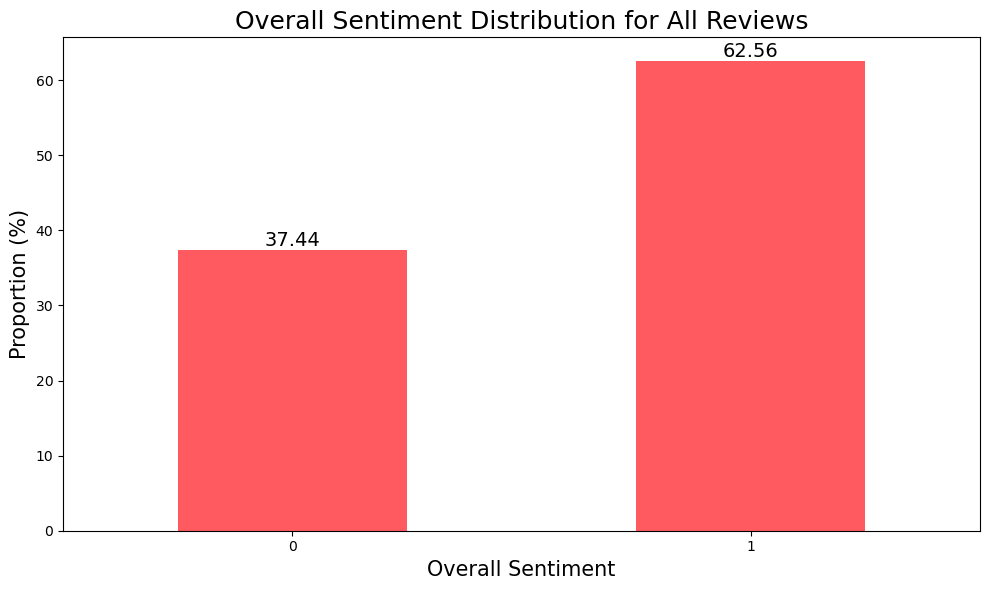

In [10]:
# Create distribution results for our target variable
overall_sentiment_distribution=round(df_reviews_by_listing['Overall_sentiment'].value_counts(normalize=True).sort_index()*100, 2)

# Determine figure size
plt.figure(figsize=(10,6))

# Create barplot
ax = overall_sentiment_distribution.plot.bar(color='#FF5A5F')

# Add labels
plt.title('Overall Sentiment Distribution for All Reviews', fontsize=18)
plt.xlabel('Overall Sentiment', fontsize=15)
plt.ylabel('Proportion (%)', fontsize=15)
plt.bar_label(ax.containers[0], size=14)
plt.xticks(rotation = 360)

plt.tight_layout()  

# plt.savefig('Overall_Sentiment_Distribution.jpg', dpi =300)
plt.show()

The current sentiment score distribution (37:63) is not as balanced as it was analysed in the listing level. This imbalance indicates a potential bias in the dataset, with a disproportionate number of reviews having positive sentiments (Overall rating > 4.8) compared to negative sentiments (Overall rating < 4.8).

To address this issue, we plan to **downsample** reviews with positive sentiments in the next sampling stage. This approach aims to create a more even distribution of the target variable, enhancing the model's ability to generalize across different sentiment categories. However, to avoid potential **data leakage**, we will only perform sampling on the **training** dataset after **Train Test Split**.

We also conclude that this imbalance may be attributed to positive review bias, where guests are more inclined to leave positive reviews. Additionally, the reinforcement effect further amplifies this bias, as the presence of positive reviews may influence subsequent guests to also leave positive reviews.

***

## Train Test Split <a id='a3.4'></a>

The modelling process starts by splitting our dataset into training and testing sets. This procedure is fundamental for the effective evaluation of our model performance.

The training data is implemented upon which our model is built and refined, and the testing data provides the benchmark for assessing the model's predictive performance on unseen data. This ensures us to mitigate the risk of **overfitting**, as our model will not just memorize the data pattern but rather learns to generalize on new, unseen data.

Additionally, it is important that this splitting process must precede any data transformation steps including random sampling, text vectorization and scaling to prevent potential **data leakage**.

In [11]:
# Split test data as 30% of all data, determine random state to make sure every split is the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Show the number of rows for training and testing dataset
print(f'The number of rows obtained in the training data is {X_train.shape[0]}, with {X_train.shape[1]} feature columns.')
print(f'The number of rows obtained in the testing data is {X_test.shape[0]}, with {X_train.shape[1]} feature columns.')

The number of rows obtained in the training data is 329450, with 38 feature columns.
The number of rows obtained in the testing data is 141194, with 38 feature columns.


***

## Sampling <a id='a3.3'></a>

Since we have a large training dataset with nearly 330k (329450) rows and an imbalanced target variable, we will perform **downsampling** on the training dataset by randomly select a balanced number of rows for both positive labelled rows and negative labelled rows.

We will eventually select 3% of the original training dataset.

In [12]:
# Define function that can perform downsampling on training data and make it perfectly balanced
def downsample_train(X_train, y_train, target, proportion):
    '''
    Function only works on target variable as binary column. 
    
    Returns downsampled X_train and y_train which
    has downsampled to specified proportion of original
    data, also makes sure y_train is balanced
    
    PARAMETERS:
    - X_train: dataframe, splitted feature training data
    - y_train: dataframe, splitted farget training data
    - target: str, target variable name
    - proportion: float, specified downsample proportion of total training data
    
    RETURNS:
    - X_train_sample: Downsampled X_train
    - y_train_sample: Downsampled y_train
    
    '''
    # Specify number of rows for each class 
    num_rows_each = round(proportion*X_train.shape[0]/2)
    
    # Temporarily concatenate X_train and y_train back to dataframe format
    df_train = pd.concat([X_train, y_train], axis=1)
    
    # Split classes
    df_pos = df_train[df_train[target] == 1]
    df_neg = df_train[df_train[target] == 0]
    
    # Resplit X and y for both two classes
    X_pos, y_pos = df_pos.drop(target, axis=1), df_pos[target]
    X_neg, y_neg = df_neg.drop(target, axis=1), df_neg[target]
    
    # Select randomized samples from each class
    X_pos_sample, y_pos_sample = resample(X_pos, y_pos, random_state=123, n_samples = num_rows_each, replace=False, stratify=y_pos)
    X_neg_sample, y_neg_sample = resample(X_neg, y_neg, random_state=123, n_samples = num_rows_each, replace=False, stratify=y_neg)
    
    # Concatenate back downsampled data
    X_train_sample = pd.concat([X_pos_sample, X_neg_sample], axis=0)
    y_train_sample = pd.concat([y_pos_sample, y_neg_sample], axis=0)
    
    return X_train_sample, y_train_sample

In [13]:
# Return downsampled training data
X_train_sample, y_train_sample = downsample_train(X_train, y_train, 'Overall_sentiment', 0.03)

In [14]:
# Check for current target variable distribution
print('The current proportion of each sentiment score class is (%)')
print((y_train_sample.value_counts(normalize=True))*100)
print('\n--------------------------------------------\n')
print(f'The current number of rows in the training data is {X_train_sample.shape[0]}')

The current proportion of each sentiment score class is (%)
1    50.0
0    50.0
Name: Overall_sentiment, dtype: float64

--------------------------------------------

The current number of rows in the training data is 9884


Thus we have downsampled our training data from nearly 330k (329450) rows to nearly 10k (9884), and we also obtained a balanced training data. We will hope that this will potentially improve our model performance and also help the models to generalize well in the testing set.

***

## Helper Function <a id='a3.5'></a>

Our dataset includes multiple non-review features, in the later text vectorization stage, it is not necessary for these columns to be processed by the vectorizers. Hence, we require a helper function to handle these numerical columns separately, and generate a column transformer based on our selection on different text vectorizers including `CountVectorizer` and `TfidfVectorizer`. 

Additionally, the numerical features in our dataset vary across different ranges, necessitating the scaling of data during the modeling stage. However, the text vectorizers will return a sparse matrix after transformation, while scalers like `StandardScaler` and `MinMaxScaler` require a dense array as input. Hence, we'll also need a function to convert the sparse matrix into a dense array.

This code is borrowed from [Allistair Cota](https://github.com/allistaircota/rate_my_restaurant/blob/main/notebooks/NB3-Modelling.ipynb).

Sources:

| Vectorizer  | Scaler| 
|:-------:|:--------:|
|[TF-IDF Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) |  [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)  |
|[Count-Vectorizer](https://en.wikipedia.org/wiki/Bag-of-words_model)  |[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) |

In [15]:
# Extract numerical column names
numeric_columns = X.select_dtypes(exclude='object').columns.to_list()

def define_col_trans(input_text, vectorizer):
    '''
    Returns a ColumnTransformer which first performs a 
    passthrough on the numeric columns, then applies
    a vectorizer on the `text` column
    
    PARAMETERS:
    - input_text: str, to name the vectorizer tuple
    - vectorizer: Sklearn text vectorizer
    
    RETURNS:
    - col_trans: sklearn ColumnTransformer
    
    '''
    
    col_trans = ColumnTransformer([
        ('numeric', 'passthrough', numeric_columns), # numerical_columns defined above
        (input_text, vectorizer, 'comments') # 'comments' as review text feature column
    ])
    
    return col_trans

def convert_to_array(sparse_matrix):
    '''
    Converts sparse matrix to dense array
    
    PARAMETERS:
    - sparse_matrix: scipy.sparse.csr_matrix or numpy array
    
    RETURNS:
    - If sparse_matrix is not a scipy.sparse.csr_matrix,
      sparse_matrix is returned. Else, returns the dense array
      form of sparse_matrix.
    
    '''
    
    if type(sparse_matrix) == csr_matrix:
    
        return sparse_matrix.toarray()
    
    else:
        return sparse_matrix

#### Text vectorizers

In [16]:
# Define column transformers
ct_bow = define_col_trans('ct_bow',  CountVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer))
ct_tfidf = define_col_trans('ct_tfidf',  TfidfVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer))

***

# Baseline Model <a id='a4'></a>

As we are developing the best performed models for predicting the class of guest sentiments, it is crucial to establish a baseline model for comparison. We will utilise a **Dummy Classifier** model, which makes predictions without accessing dataset features, essentially performing random guessing. By establishing this baseline, we can decide that any model performing worse than the baseline model will not proceed to further analysis.

**Run Time**: 4mins 46s

In [17]:
# Vectorize data using Bag of Words Vectorizer
bow_vec = CountVectorizer(max_features = 500, # Only obtain top 500 features based on vectorizer results
                            min_df=5, # Feature occurency should be bigger than 5 in the corpus
                            tokenizer=customized_tokenizer)

# Fit and transform on the vectorizer to training data
X_train_tfidf_d = bow_vec.fit_transform(X_train_sample['comments']).toarray()

# Transform on both training data and testing data
X_test_tfidf_d = bow_vec.transform(X_test['comments']).toarray()

# Reset Index before concatenating
X_train_sample_reset_index = X_train_sample.reset_index(drop=True)
X_test_reset_index = X_test.reset_index(drop=True)

# Merge the resulting arrays with the original numeric features
X_train_tfidf_d_transformed = pd.concat([X_train_sample_reset_index.drop(['comments'], axis=1),
                                         pd.DataFrame(X_train_tfidf_d, columns=[i for i in bow_vec.get_feature_names_out()])], axis=1)

X_test_tfidf_d_transformed = pd.concat([X_test_reset_index.drop(['comments'], axis=1), 
                                        pd.DataFrame(X_test_tfidf_d, columns=[i for i in bow_vec.get_feature_names_out()])], axis = 1)

# Print shape of the vectorized training feature data
print(f'X_train_transfomed_dummy : {X_train_tfidf_d_transformed.shape}')

X_train_transfomed_dummy : (9884, 537)


In [18]:
# # Dummy Classifier - Baseline Model
# Instantiate Dummy Classifier
dummy_classifier = DummyClassifier()

# Fit the Dummy Classifier on Training data
dummy_classifier.fit(X_train_tfidf_d_transformed, y_train_sample)

# Predict the fitted model on Testing Data
y_predict_d = dummy_classifier.predict(X_test_tfidf_d_transformed)

# Print F1 score
print(f'The Accuracy Score (%) for the Baseline Model is: {round(accuracy_score(y_test, y_predict_d)*100, 2)} %')

The Accuracy Score (%) for the Baseline Model is: 37.49 %


#### Classification report <a id='a4.1'></a>

In [19]:
# Generate classification report to see specific classification evaluation metrics scores
baseline_report = classification_report(y_test, y_predict_d)
print(baseline_report)

              precision    recall  f1-score   support

           0       0.37      1.00      0.55     52931
           1       0.00      0.00      0.00     88263

    accuracy                           0.37    141194
   macro avg       0.19      0.50      0.27    141194
weighted avg       0.14      0.37      0.20    141194



Based on the findings from the classification report, the model classification accuracy score achieved by the dummy classifier is **37.49%**. This baseline performance indicates that future models should aim to surpass this threshold to be considered effective. Therefore, our goal for future models is to achieve an accuracy score higher than 38%, indicating improved predictive capability and accuracy in classifying sentiments. 

**Note**: This result is reflected by the actual proportion of negative sentiments in the testing dataset as Dummy Classifier takes random guesses.

***

# Modelling <a id='a5'></a>

After completing data cleaning, pre-processing, and model setup stages, we are ready to train models and make predictions. To determine the best-performing model, we will utilize **GridSearchCV** where several classification models with wide ranges of hyperparameters are included to find the optimal model with the best hyperparameters. Machine learning metrics and models to be used in our modeling process include:

- Text Vectorizer: Bag of Words, TF-IDF
- Scaler: StandardScaler
- Models: Logistic Regression, Decision Tree Classifier, Random Forest Classifier.

Note that for performance purposes, we will be vectorizing the datasets outside of grid search. We will then fit combinations of models to the training data that has been transformed by two types of text vectorizations. During the fitting process, **5-fold cross-validation** will be performed to improve model performance and interpretability. Finally, the model with the highest average validation F1 score will be selected and evaluated at the end of each GridSearch.

**Note**: The **F1** score is selected as the evaluation metric instead of the **accuracy** score due to imbalance in the pre-downsampled training dataset. We will conduct a more specific evaluation process upon model selection.

## GridSearch_1: General Sweep <a id='a5.1'></a>

During the first GridSearch, we will be searching for optimal hyperparameters over wide range implementing on the **Logistic Regresion** and **Decision Tree Classifier**. This GridSearch will be run and fitted on two vectorized training sets defined above and we will evaluate the model performances with a brief summary. The included models and their hyperparameters in the **GridSearch_1** are summarized below:

|    Models   |    Hyperparameters   |   Ranges/Options  |
|:-------------:|:-------------:|:-------------:|
|    **TfidfVectorizer**     |     max_df   |    0.95     |
|                  |     min_df  |    5       |
|       **CountVectorizer**           |     max_df  |    0.95       |
|                  |     min_df  |    5       |
|    **Logistic Regression**     |    C     |    0.001, 0.01, 0.1, 1, 10    |
|         |    penalty     |    'none', 'l2'     | 
|    **Decision Tree Classifier**     |     max_depth    |     2, 8, 32, 64, 128    |
|                 |    min_samples_leaf     |     2, 4, 8    |
|                 |     min_samples_split    |     2, 4, 8    |
|                 |     criterion    |     'gini', 'entropy'    |

### First Gridsearch <a id='a5.1.1'></a>

Run Time: 41 mins 41s

To save long execution times for future references, we will use a loading flag to prevent re-training models when it is already saved and can be loaded as a pickle file

In [22]:
# # First GridSearch

#-----------------------------------------------------------------------------------------------------------------#
# Fit and transform on training data using two types of vectorizers
print('Transforming training sample data .....')
X_train_ct_bow = ct_bow.fit_transform(X_train_sample)
X_train_ct_tfidf= ct_tfidf.fit_transform(X_train_sample)
print('Training sample data transformed.')
#-----------------------------------------------------------------------------------------------------------------#

# If one needs to retrain the model, set loading flag as False
loaded_flag_1 = False

if loaded_flag_1:
    print('Loaded pre-trained models (Gridsearch_1)')
    # Load saved fittedgrid
    fittedgrid_1_bow=joblib.load('data/fittedgrid_1_bow.pkl')
    fittedgrid_1_tfidf=joblib.load('data/fittedgrid_1_tfidf.pkl')
else:
    # Define base pipeline
    pipeline_1 = Pipeline([
        ('sparse_to_dense', FunctionTransformer(convert_to_array, accept_sparse=True)),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])
    
    # Instantiate Pipeline with grid of parameters
    grid_param_1 = [

        # Logistic Regression
        {
            'model'              : [LogisticRegression()],
            'model__C'           : [0.001, 0.01, 0.1, 1, 10], # C parameter to control penalty weights
            'model__penalty'     : ['none', 'l2'], # Control penalty types, l1: Lasso, l2: Ridge
            'model__random_state': [123], # Control gradient descent starting point
            'model__max_iter'    : [10000] # Make sure model iterates
        },

        # Decision Tree Classifier
        {
            'model'                   : [DecisionTreeClassifier()],
            'model__max_depth'        : [2, 8, 32, 64, 128], # Control number of tree splits/depth
            'model__min_samples_leaf' : [2, 4, 8], # Control minimum number of samples at a leaf node
            'model__min_samples_split': [2, 4, 8], # Control minimum number of samples split at a leaf node
            'model__criterion'        : ['gini', 'entropy'], # Control the function to measure the quality of a split
            'model__random_state'     :[123] # Control randomness of the estimator
        }
    ]

    # Use GridSearch
    grid_1 = GridSearchCV(estimator=pipeline_1, # Define GridSearch estimator pipeline
                         param_grid=grid_param_1, # Define parameter grid
                         cv=5, # Define 5-fold cross-validation
                         n_jobs=-2,
                         scoring='f1') 

    # Fit the grid on training data
    fittedgrid_1_bow = grid_1.fit(X_train_ct_bow, y_train_sample)
    fittedgrid_1_tfidf = grid_1.fit(X_train_ct_tfidf, y_train_sample)
    
    # Save fittedgrid as pickle file
    joblib.dump(fittedgrid_1_bow, 'data/fittedgrid_1_bow.pkl')
    joblib.dump(fittedgrid_1_tfidf, 'data/fittedgrid_1_tfidf.pkl')

Transforming training sample data .....
Training sample data transformed.


***

### First GridSearch Results <a id='a5.1.2'></a>

#### Selected model results with Bag of Words transformed data (Gridsearch_1)

In [23]:
print('\n--------------------\n')
print(fittedgrid_1_bow.best_estimator_)

# Print Crossvalidated Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_1_bow.score(X_train_ct_bow, y_train_sample)*100.00, 2)}') 

# Print Testing Score
print('\n--------------------\n')

# Vectorize on testing data to evaluate model actual performance
X_test_ct_bow = ct_bow.transform(X_test)
print(f'Best Model Test Score (%): {round(fittedgrid_1_bow.score(X_test_ct_bow, y_test)*100, 2)}') 


--------------------

Pipeline(steps=[('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function convert_to_array at 0x00000293F1E853A0>)),
                ('scaler', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=32,
                                        min_samples_leaf=2,
                                        random_state=123))])

--------------------

Best Model Train Score (%): 97.35

--------------------

Best Model Test Score (%): 93.62


#### Selected model results with TF-IDF transformed data (Gridsearch_1)

In [24]:
print('\n--------------------\n')
print(fittedgrid_1_tfidf.best_estimator_)

# Print Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_1_tfidf.score(X_train_ct_tfidf, y_train_sample)*100.00, 2)}') 

# Print Testing Score
print('\n--------------------\n')

# Vectorize on testing data to evaluate model actual performance
X_test_ct_tfidf = ct_tfidf.transform(X_test)
print(f'Best Model Test Score (%): {round(fittedgrid_1_tfidf.score(X_test_ct_tfidf, y_test)*100, 2)}') 


--------------------

Pipeline(steps=[('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function convert_to_array at 0x00000293F1E853A0>)),
                ('scaler', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=32,
                                        min_samples_leaf=2,
                                        random_state=123))])

--------------------

Best Model Train Score (%): 99.24

--------------------

Best Model Test Score (%): 94.56


#### Top 10 models with best F1 scores resulted with TF-IDF transformed data (Gridsearch_1)

In [25]:
# Expand column width to see full results
pd.set_option('display.max_colwidth', None)

# Store results in a dataframe by sorting mean_test_score in descending order
fittedgrid1_results_df = pd.DataFrame(fittedgrid_1_tfidf.cv_results_).sort_values('mean_test_score', ascending=False)

# Extract ranking number, models with tuned hyperparameters, and corresponding test scores
fittedgrid1_results = fittedgrid1_results_df[['rank_test_score', 'params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)
print('GridSearch_1 Cross_Validation Results')

# Show top 10 cross validation results
fittedgrid1_results.head(10) 

GridSearch_1 Cross_Validation Results


,rank_test_score,params,mean_test_score
92,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 128, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.912732
74,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 32, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.912732
82,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 64, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.912732
83,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 64, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.912732
91,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 128, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.912732
73,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 32, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.912732
84,7,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 64, 'model__min_samples_leaf': 2, 'model__min_samples_split': 8, 'model__random_state': 123}",0.910225
75,7,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 32, 'model__min_samples_leaf': 2, 'model__min_samples_split': 8, 'model__random_state': 123}",0.910225
93,7,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 128, 'model__min_samples_leaf': 2, 'model__min_samples_split': 8, 'model__random_state': 123}",0.910225
85,10,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 64, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__random_state': 123}",0.904958


Next, we will study the currently selected best model in more detail by examining if there are patterns in its misclassified reviews. We will first obtain the more specific evaluation results by looking at the classification report and plotting a corresponding confusion matrix.

#### GridSearch_1 Best Model Confusion Matrix

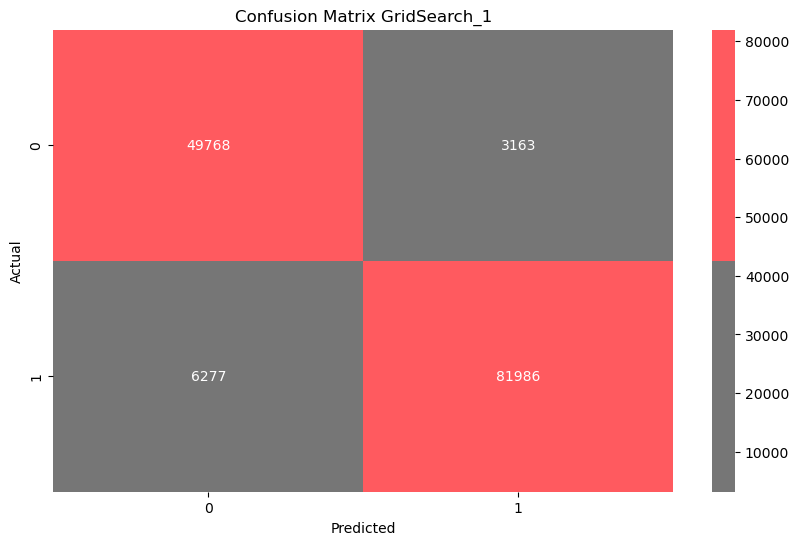

In [26]:
# Test data predictions 
y_pred_grid1 = fittedgrid_1_tfidf.best_estimator_.predict(X_test_ct_tfidf)

# Compute Confusion Matrix
Confusion_Matrix_grid1 = confusion_matrix(y_test, y_pred_grid1)

# Define the colors in hex format
colors_hex = ['#767676', '#FF5A5F']

# Create a colormap using ListedColormap
custom_cmap = ListedColormap(colors_hex)

# Determine plot size
plt.figure(figsize=(10, 6))

# Plot confusion matrix heatmap
sns.heatmap(Confusion_Matrix_grid1, annot=True, cmap = custom_cmap, fmt='d')

# Add labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix GridSearch_1')

plt.show()

#### GridSearch_1 Classification Report

In [27]:
# Show best model test data classification report
print(classification_report(y_test, y_pred_grid1))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     52931
           1       0.96      0.93      0.95     88263

    accuracy                           0.93    141194
   macro avg       0.93      0.93      0.93    141194
weighted avg       0.93      0.93      0.93    141194



### GridSearch_1 Result Summary <a id='a5.1.3'></a>

- We eventually found the best model from the first gridsearch with a training score of **99.15%** and a testing score of **94.56%** (F1 Score). These high scores indicate that our model fitted very well on the sampled training dataset and managed to capture most of the data patterns to make predictions on the testing dataset. Additionally, compare to the baseline dummy classifier, our model outperformes the 54% F1 score by more than **40%**. 
- By extracting the cross validation scores for all of the combinations of hyperparameters for both of the classifier models, we observed that **Decision Tree Classifier** outperforms all of the **Logistic Regression** models. Therefore, in the next **N-grams** Gridsearch, we will only include the Decision Tree Classifier and bring in **Random Forest** Models to expect better model performances.

***

## GridSearch_2 : Ngrams <a id='a5.2'></a>

After the first grid search, we obtained more focused parameter ranges and a currently best performed DT model. Our next step is to aim for better interpretability and hopefully further enhance our model performance by adding **n-grams** to the vectorizer. 

N-grams are essentially pairs of consecutive words that help maintain the sequence and interpretability of the tokens. In our second grid search, we will use bigrams (2 words), trigrams (3 words), and remove single words for both the bag-of-words vectorizer and the TF-IDF vectorizer.

Additionally, we will bring in **Random Forest Classifiers** in this gridsearch and narrow down our classifer hyperparameter ranges based on the previous GridSearch results.

|    Models   |    Hyperparameters   |   Ranges/Options  |
|:-------------:|:-------------:|:-------------:|
|    **TfidfVectorizer**     |     max_df   |    0.95     |
|                  |     min_df  |    5       |
|                  |     N_grams  |    bigrams, trigrams       |
|       **CountVectorizer**           |     max_df  |    0.95       |
|                  |     min_df  |    5       |
|                  |     N_grams  |    bigrams, trigrams       |
|    **Decision Tree Classifier**     |     max_depth    |     32, 64, 128    |
|                 |    min_samples_leaf     |     2    |
|                 |     min_samples_split    |     2, 3, 4    |
|                 |     criterion    |    'entropy'    |
|    **Random Forest Classifier**     |     n_estimators    |     5, 10, 15    |
|                              |     max_depth    |     32, 64, 128    |
|                 |    min_samples_leaf     |     2   |
|                 |     criterion    |    'entropy'    |

### Second GridSearch <a id='a5.2.1'></a>

Run time: 7 mins 22s

In [28]:
# # Second GridSearch

#-----------------------------------------------------------------------------------------------------------------#
# Define column transformers with ngrams added
ct_bow_ngrams = define_col_trans('ct_bow',  CountVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer, ngram_range=(2, 3)))
ct_tfidf_ngrams = define_col_trans('ct_tfidf',  TfidfVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer, ngram_range=(2, 3)))

# Fit and transform on training data using new vectorizers
print('Transforming training sample data .....')
X_train_ct_bow_ngrams = ct_bow_ngrams.fit_transform(X_train_sample)
X_train_ct_tfidf_ngrams= ct_tfidf_ngrams.fit_transform(X_train_sample)
print('Training sample data transformed.')
#-----------------------------------------------------------------------------------------------------------------#
# If one needs to retrain the model, set loading flag as False
loaded_flag_2 = False

if loaded_flag_2:
    print('Loaded pre-trained models (Gridsearch_2)')
    # Load saved fittedgrid
    fittedgrid_2_bow=joblib.load('data/fittedgrid_2_bow.pkl')
    fittedgrid_2_tfidf=joblib.load('data/fittedgrid_2_tfidf.pkl')
else:

    # Define base pipeline
    pipeline_2 = Pipeline([
        ('sparse_to_dense', FunctionTransformer(convert_to_array, accept_sparse=True)),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])

    # Instantiate Pipeline with grid of parameters
    grid_param_2 = [

        # Decision Tree Classifier
        {
            'model'                   : [DecisionTreeClassifier()],
            'model__max_depth'        : [32, 64, 128], # Control number of tree splits/depth
            'model__min_samples_leaf' : [2], # Control minimum number of samples at a leaf node
            'model__min_samples_split': [2, 3, 4], # Control minimum number of samples split at a leaf node
            'model__criterion'        : ['entropy'], # Control the function to measure the quality of a split
            'model__random_state'     : [123] # Control randomness of the estimator
        },

        # Random Forest
        {
            'model'                   : [RandomForestClassifier()],
            'model__n_estimators'     : [5, 10, 15], # Control number of trees in the forest
            'model__max_depth'        : [32, 64, 128], # Control number of tree splits/depth
            'model__min_samples_leaf' : [2], # Control minimum number of samples at a leaf node
            'model__criterion'        : ['gini', 'entropy'], # Control the function to measure the quality of a split
            'model__random_state'     : [123] # Control randomness of the estimator  
        }  
    ]

    # Use GridSearch
    grid_2 = GridSearchCV(estimator=pipeline_2, # Define GridSearch estimator pipeline
                         param_grid=grid_param_2, # Define parameter grid
                         cv=5, # Define 5-fold cross-validation
                         n_jobs=-2,
                         scoring='f1',
                         verbose=1) # Define GridSearch evaluation metric to be f1 score

    # Fit the grid on training data
    fittedgrid_2_bow = grid_2.fit(X_train_ct_bow_ngrams, y_train_sample)
    fittedgrid_2_tfidf = grid_2.fit(X_train_ct_tfidf_ngrams, y_train_sample)
    
    # Save fittedgrid as pickle file
    joblib.dump(fittedgrid_2_bow, 'data/fittedgrid_2_bow.pkl')
    joblib.dump(fittedgrid_2_tfidf, 'data/fittedgrid_2_tfidf.pkl')

Transforming training sample data .....
Training sample data transformed.
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


***

### Second GridSearch Results <a id='a5.2.2'></a>

#### Selected model results with Bag of Words transformed data (Gridsearch_2)

In [29]:
print('\n--------------------\n')
print(fittedgrid_2_bow.best_estimator_)

# Print Crossvalidated Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_2_bow.score(X_train_ct_bow_ngrams, y_train_sample)*100.00, 2)}') 

# Print Testing Score
print('\n--------------------\n')

# Vectorize on testing data to evaluate model actual performance
X_test_ct_bow_ngrams = ct_bow_ngrams.transform(X_test)
print(f'Best Model Test Score (%): {round(fittedgrid_2_bow.score(X_test_ct_bow_ngrams, y_test)*100, 2)}') 


--------------------

Pipeline(steps=[('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function convert_to_array at 0x00000293F1E853A0>)),
                ('scaler', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=32,
                                        min_samples_leaf=2,
                                        random_state=123))])

--------------------

Best Model Train Score (%): 99.08

--------------------

Best Model Test Score (%): 95.73


#### Selected model results with TF-IDF transformed data (Gridsearch_2)

In [30]:
print('\n--------------------\n')
print(fittedgrid_2_tfidf.best_estimator_)

# Print Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_2_tfidf.score(X_train_ct_tfidf_ngrams, y_train_sample)*100.00, 2)}') 

# Print Testing Score
print('\n--------------------\n')

# Vectorize on testing data to evaluate model actual performance
X_test_ct_tfidf_ngrams = ct_tfidf_ngrams.transform(X_test)
print(f'Best Model Test Score (%): {round(fittedgrid_2_tfidf.score(X_test_ct_tfidf_ngrams, y_test)*100, 2)}') 


--------------------

Pipeline(steps=[('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function convert_to_array at 0x00000293F1E853A0>)),
                ('scaler', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=32,
                                        min_samples_leaf=2,
                                        random_state=123))])

--------------------

Best Model Train Score (%): 99.2

--------------------

Best Model Test Score (%): 95.78


#### Top 10 models with best F1 scores resulted with TF-IDF transformed data (Gridsearch_2)

In [31]:
# Store results in a dataframe by sorting mean_test_score in descending order
fittedgrid2_results_df = pd.DataFrame(fittedgrid_2_tfidf.cv_results_).sort_values('mean_test_score', ascending=False)

# Extract ranking number, models with tuned hyperparameters, and corresponding test scores
fittedgrid2_results = fittedgrid2_results_df[['rank_test_score', 'params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)
print('GridSearch_2 Cross_Validation Results')

# Show top 10 cross validation results
fittedgrid2_results.head(10) 

GridSearch_2 Cross_Validation Results


,rank_test_score,params,mean_test_score
0,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 32, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.927352
1,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 32, 'model__min_samples_leaf': 2, 'model__min_samples_split': 3, 'model__random_state': 123}",0.927352
2,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 32, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.927352
3,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 64, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.927352
4,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 64, 'model__min_samples_leaf': 2, 'model__min_samples_split': 3, 'model__random_state': 123}",0.927352
5,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 64, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.927352
6,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 128, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__random_state': 123}",0.927352
7,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 128, 'model__min_samples_leaf': 2, 'model__min_samples_split': 3, 'model__random_state': 123}",0.927352
8,1,"{'model': DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2, random_state=123), 'model__criterion': 'entropy', 'model__max_depth': 128, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__random_state': 123}",0.927352
17,10,"{'model': RandomForestClassifier(), 'model__criterion': 'gini', 'model__max_depth': 128, 'model__min_samples_leaf': 2, 'model__n_estimators': 15, 'model__random_state': 123}",0.825332


#### GridSearch_2 Best Model Confusion Matrix

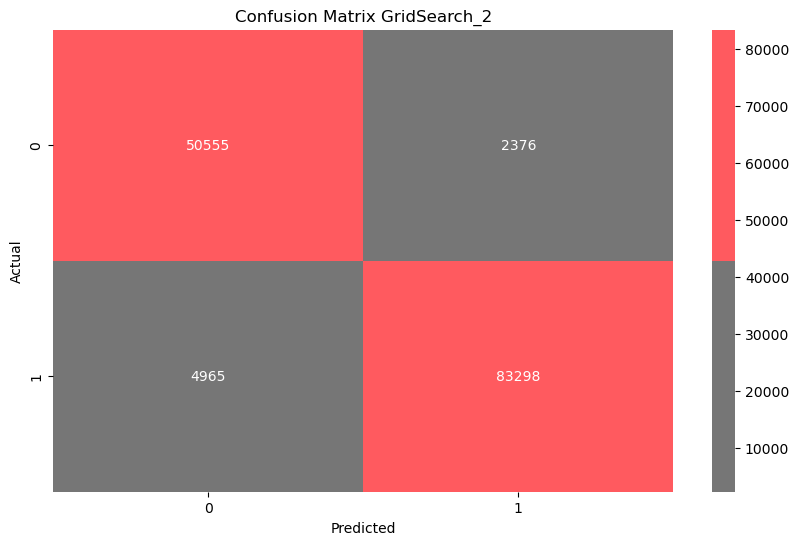

In [32]:
# Test data predictions 
y_pred_grid2 = fittedgrid_2_tfidf.best_estimator_.predict(X_test_ct_tfidf_ngrams)

# Compute Confusion Matrix
Confusion_Matrix_grid2 = confusion_matrix(y_test, y_pred_grid2)

# Define the colors in hex format
colors_hex = ['#767676', '#FF5A5F']

# Create a colormap using ListedColormap
custom_cmap = ListedColormap(colors_hex)

# Determine plot size
plt.figure(figsize=(10, 6))

# Plot confusion matrix heatmap
sns.heatmap(Confusion_Matrix_grid2, annot=True, cmap = custom_cmap, fmt='d')

# Add labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix GridSearch_2')

plt.show()

#### GridSearch_2 Classification Report

In [33]:
# Show best model test data classification report
print(classification_report(y_test, y_pred_grid2))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93     52931
           1       0.97      0.94      0.96     88263

    accuracy                           0.95    141194
   macro avg       0.94      0.95      0.95    141194
weighted avg       0.95      0.95      0.95    141194



### GridSearch_2 Result Summary <a id='a5.2.3'></a>

The main purpose of performing an N-grams grid search is to achieve better interpretability and hopefully improve model performance. After the second grid search, we obtained the following results:

- The best model obtained from this second grid search outperforms the first one by **1.22%** (F1 Score), arriving at **95.78%**. Additionally, while both selected models are Decision Tree Classifiers with 2 minimum samples per leaf, the maximum tree depth for the second model is **32** compared to **64** for the first selected model. This indicates that our newly selected model can converge to optimal results sooner than the previous model.
- Furthermore, upon examining the confusion matrix, we found that based on the plotted confusion matrix, our newly selected model makes fewer mistakes in predicting actual less outstanding listings (class 0) as outstanding (class 1). This suggests that by vectorizing data using pairwise or triple-wise words, our model manages to capture patterns better compared to single-word vectorizers.

***

# Summary <a id='a6'></a>

We eventually conducted two grid searches and obtained the following modeling results. The results, including the selected model hyperparameters, will be presented in a dataframe below. 

Our next step is to perform the same analysis on the other review dataset: **'df_collapsed_reviews_by_listing'**. In the collapsed review dataset, reviews for the same listing are condensed into a single paragraph for each listing, resulting in a much smaller number of data points with much larger review texts in each row. The main purpose of this analysis is to potentially achieve better interpretability once we have trained our model. Since our star rating threshold was defined on the listing level, not on individual reviews, our analysis in this notebook assumed that **all reviews share the same listing star rating** which achieved good model performance but sacrificed model interpretability. In the finall **7_Findings** notebook, we will discuss the feature extracted from the selected models and the potential reasons for the misclassified datapoints from our models.

In [36]:
# Review Uncollapsed Reviews Modelling Results
fittedgrid_results_uncollapsed = [['Dummy','Dummy Classifier' ,'','', round(accuracy_score(y_test, y_predict_d)*100, 2)],
                   ['GridSearch_1_General_Sweep', 
                    fittedgrid_1_tfidf.best_estimator_, 
                    round(fittedgrid_1_bow.score(X_train_ct_bow, y_train_sample)*100.00, 2),
                    round(fittedgrid_1_tfidf.score(X_train_ct_tfidf, y_train_sample)*100.00, 2), 
                    round(fittedgrid_1_tfidf.score(X_test_ct_tfidf, y_test)*100.00,2)],
                   ['GridSearch_2_N_grams', 
                    fittedgrid_2_tfidf.best_estimator_, 
                    round(fittedgrid_2_bow.score(X_train_ct_bow_ngrams, y_train_sample)*100.00, 2), 
                    round(fittedgrid_2_tfidf.score(X_train_ct_tfidf_ngrams, y_train_sample)*100.00, 2),
                    round(fittedgrid_2_tfidf.score(X_test_ct_tfidf_ngrams, y_test)*100.00,2)]]



fittedgrid_df_uncollapsed = pd.DataFrame(fittedgrid_results_uncollapsed, columns = ['Modelling Title', 
                                                                                    'Best_Estimator', 
                                                                                    'Best_Bow_Transformed_Training_Score', 
                                                                                    'Best_TF_IDF_Transformed_Training_Score',
                                                                                    'Best_TF_IDF_Transformed_Testing_Score'])

In [37]:
# Show all estimator parameters
pd.set_option('display.max_colwidth', 1000)

# Show dataframe
fittedgrid_df_uncollapsed.T

,0,1,2
Modelling Title,Dummy,GridSearch_1_General_Sweep,GridSearch_2_N_grams
Best_Estimator,Dummy Classifier,"(FunctionTransformer(accept_sparse=True,\n func=<function convert_to_array at 0x00000293F1E853A0>), StandardScaler(), DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2,\n random_state=123))","(FunctionTransformer(accept_sparse=True,\n func=<function convert_to_array at 0x00000293F1E853A0>), StandardScaler(), DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=2,\n random_state=123))"
Best_Bow_Transformed_Training_Score,,97.35,99.08
Best_TF_IDF_Transformed_Training_Score,,99.24,99.2
Best_TF_IDF_Transformed_Testing_Score,37.49,94.56,95.78
